In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset
from theano import tensor as T

/home/nilavro/irleak/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
blue = sns.color_palette()[0]
np.random.seed(462233) # from random.org


In [7]:
N = 5
K = 30

alpha = 2
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)
x_plot = np.linspace(-3, 3, 200)
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(N, K))

dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

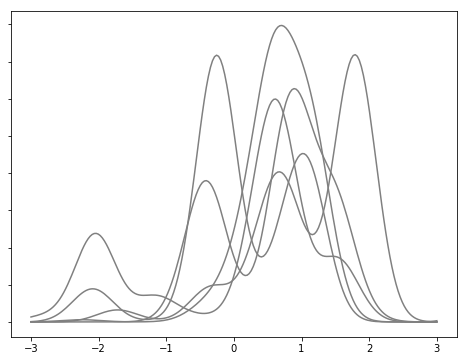

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c='gray');

ax.set_yticklabels([]);

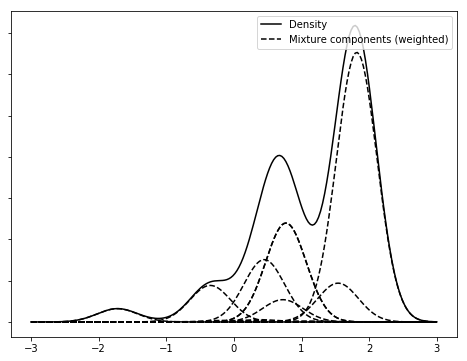

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c='k', label='Density');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
        '--', c='k', label='Mixture components (weighted)');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T,
        '--', c='k');

ax.set_yticklabels([]);
ax.legend(loc=1);

In [11]:
old_faithful_df = get_rdataset('faithful', cache=True).data[['waiting']]
old_faithful_df.head()

,waiting
0,79
1,54
2,74
3,62
4,85


In [12]:
old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()

In [13]:
old_faithful_df.head()


,waiting,std_waiting
0,79,0.596025
1,54,-1.242890
2,74,0.228242
3,62,-0.654437
4,85,1.037364


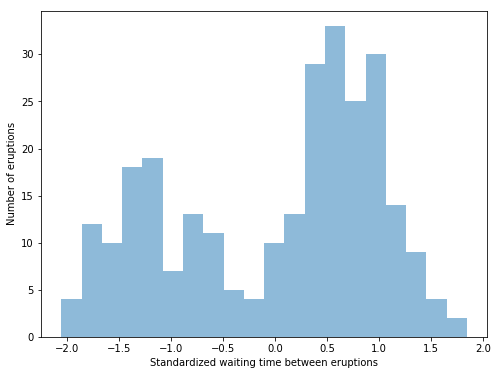

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color=blue, lw=0, alpha=0.5);

ax.set_xlabel('Standardized waiting time between eruptions');
ax.set_ylabel('Number of eruptions');

In [21]:
N = old_faithful_df.shape[0]

K = 10

In [22]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))
    component = pm.Categorical('component', w, shape=N)

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, lambda_ * tau, shape=K)
    obs = pm.Normal('obs', mu[component], lambda_[component] * tau[component],
                    observed=old_faithful_df.std_waiting.values)

In [20]:
SEED = 5132290 # from random.org

with model:
    trace = pm.sample(2000, random_seed=SEED)

/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, lambda_interval__, tau_log__, beta_logodds__, alpha_log__]
>CategoricalGibbsMetropolis: [component]
 94%|█████████▍| 2362/2500 [09:12<00:32,  4.27it/s]/home/nilavro/irleak/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 97%|█████████▋| 2434/2500 [09:25<00:15,  4.31it/s]/home/nilavro/irleak/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 2500/2500 [09:36<00:00,  4.33it/s]/home/nilavro/irleak/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty 

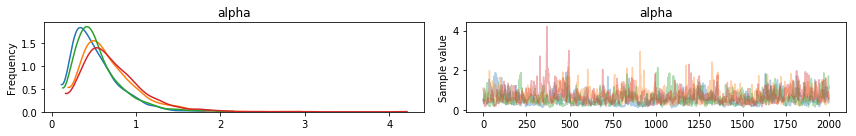

In [23]:
pm.traceplot(trace, varnames=['alpha']);


In [24]:
with model:
    mean_field = pm.fit(method='advi', n=5000, callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])

Average Loss = inf: 100%|██████████| 5000/5000 [00:03<00:00, 1625.90it/s]
Finished [100%]: Average Loss = nan


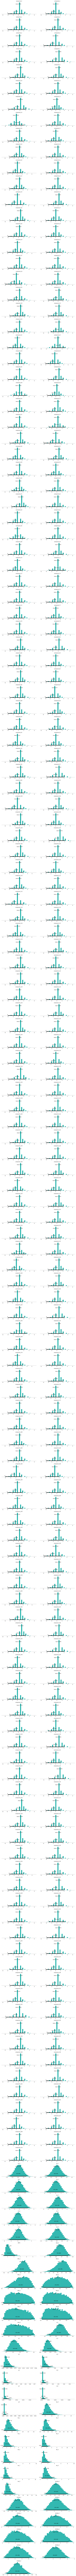

In [25]:
pm.plot_posterior(mean_field.sample(10000), color='LightSeaGreen');


with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, lambda_, tau, mu, obs])
    step2 = pm.ElemwiseCategorical([component], np.arange(K))
    
    trace_ = pm.sample(20000, [step1, step2])

trace = trace_[10000::10]

In [ ]:
pm.traceplot(trace, varnames=['alpha']);



In [ ]:
n_components_used = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component'])
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(n_components_used.min(), n_components_used.max() + 1)
ax.hist(n_components_used + 1, bins=bins, normed=True, lw=0, alpha=0.75);

ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of mixture components used');

ax.set_ylabel('Posterior probability');